https://colab.research.google.com/notebooks/mlcc/validation.ipynb?utm_source=mlcc&utm_campaign=colab-external&utm_medium=referral&utm_content=validation-colab&hl=en

### Learning Objetives:
  - Use multiple features, instead of a single feature, to further improve the effectivness of a model
  - Debug issues in model input data
  - Use a test data set to check if a model is overfitting the validation data

## Setup

Let's load up and prepare our data. This time, we'll be using multiple features, so we'll modularize the logic for preprocessing the features a bit:

In [1]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

C:\Users\bradburj\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def preprocess_features(california_housing_dataframe):
    """Prepares input features from California housing data set.
    
    Args:
        california_housing_dataframe: A Pandas DataFrame expected to contain data
            from the California housing data set.
    Returns:
        A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    selected_features = california_housing_dataframe[
        ["latitude",
        "longitude",
        "housing_median_age",
        "total_rooms",
        "total_bedrooms",
        "population",
        "households",
        "median_income"]
    ]
    processed_features = selected_features.copy()
    # Create a synthetic feature
    processed_features["rooms_per_person"] = (
        california_housing_dataframe["total_rooms"] /
        california_housing_dataframe["population"])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    """Prepares target features (i.e., labels) from California housing data set.
    
    Args:
        california_housing_data_frame: A Pandas DataFrame expected to contain data
            from the California housing data set.
    Returns:
        A DataFrame that contains the target feature.
    """
    output_targets = pd.DataFrame()
    # Scale the target to be in units of thousands of dollars.
    output_targets["median_house_value"] = (
        california_housing_dataframe["median_house_value"] / 1000.0)
    return output_targets

For the **training set**, we'll choose the first 12000 examples, out of the total of 17000.

In [3]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,34.6,-118.5,27.5,2655.7,547.1,1476.0,505.4,3.8,1.9
std,1.6,1.2,12.1,2258.1,434.3,1174.3,391.7,1.9,1.3
min,32.5,-121.4,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.8,-118.9,17.0,1451.8,299.0,815.0,283.0,2.5,1.4
50%,34.0,-118.2,28.0,2113.5,438.0,1207.0,411.0,3.5,1.9
75%,34.4,-117.8,36.0,3146.0,653.0,1777.0,606.0,4.6,2.3
max,41.8,-114.3,52.0,37937.0,5471.0,35682.0,5189.0,15.0,55.2


In [5]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,198.0
std,111.9
min,15.0
25%,117.1
50%,170.5
75%,244.4
max,500.0


For the **validation set**, we'll choose the last 5000 examples out of the total of 17000.

In [6]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,38.1,-122.2,31.3,2614.8,521.1,1318.1,491.2,4.1,2.1
std,0.9,0.5,13.4,1979.6,388.5,1073.7,366.5,2.0,0.6
min,36.1,-124.3,1.0,8.0,1.0,8.0,1.0,0.5,0.1
25%,37.5,-122.4,20.0,1481.0,292.0,731.0,278.0,2.7,1.7
50%,37.8,-122.1,31.0,2164.0,424.0,1074.0,403.0,3.7,2.1
75%,38.4,-121.9,42.0,3161.2,635.0,1590.2,603.0,5.1,2.4
max,42.0,-121.4,52.0,32627.0,6445.0,28566.0,6082.0,15.0,18.3


In [8]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,229.5
std,122.5
min,15.0
25%,130.4
50%,213.0
75%,303.2
max,500.0


## Task 1: Examine the Data
Okay, let's look at the data above. We have 9 input features that we can use.

Take a quick skim over the table of values. Everything look okay? See how many issues you can spot.

First, check our data against some baseline expectations:
  - For some values, like `median_house_value`, we can check to see if these values fall within reasonable ranges (keeping in mind this was 1990 data)
  - For other values, like `latitude` and `longitude`, we can do a quick check to see if these line up with expected values from a quick Google search.

If you look closely, you may see some oddities:
  - `meadian_income` is on a scale from about 3 to 15. It's not clear what this scale refers to - looks like maybe some log scale? It's not documented anywhere; all we can assume is that higher values correrspond to higher income.
  - The maximum `median_house_value` is 500,000. This looks like an artificial cap of some kind.
  - Our `rooms_per_person` feature is generally on a sane scale, with a 75th percentile value of about 2. But there are some very large values, like 18 or 55, which may shpw some ammount of corruption in the data.
  
We'll use these features as given for now. But hopefully these kinds of wxamples can help to build a little intuition about how to check data that comes to you from an unkown source.

## Task 2: Plot Latitude/Lontitude vs. Median House Value
Let's take a close look at two features in particular: **`latititude`** and **`longitude`**. These are geographical coordinates of the city block in question.

This might make a nice visualization - let's plot `latitude` and `longitude` and use colour to show the `median_house_value`.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

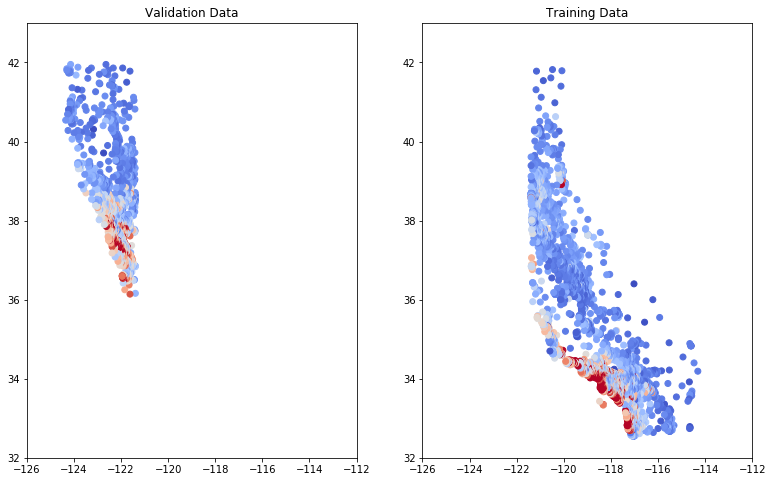

In [14]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
           validation_examples["latitude"],
           cmap="coolwarm",
           c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
           training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

_ = plt.plot()

Wait a second ... this should have given us a nice map of the state of California, with red showing up in expensive areads like San Francisco and Los Angeles.

The trainig set looks about right, but the validation set does not.

Looking at the tables of summary stats above, it's easy to wonder how anyone would do a useful data check. What's the right 75<sup>th</sup> percentile value for `total_rooms` per city block?

The key thing to notice is that for any given feature or column, the distribution of values between the train and validation splits should be roughly equal.

The fact that this is not the case is a real worry, and shows that we likely have a fault in the way that our train and validation split was created.

## Task 3: Return to the Data Importing and Pre-Processing Code, and See if You Spot Any Bugs
The issue is that the data is not randomized before creating the training and validation splits. This can cause issues if the data is given to us in some sorted order, which appears to be the case here.

Important lesson here:

**Debugging in ML is often *data debugging* rather than coe debugging.**

If the data is wrong, even the most advanced ML code can't save things.

In [18]:
california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [19]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.7,2633.4,538.5,1429.3,500.4,3.9,2.0
std,2.1,2.0,12.5,2193.7,423.5,1177.6,387.1,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1453.0,296.0,786.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2116.0,432.0,1165.0,407.0,3.5,1.9
75%,37.7,-118.0,37.0,3137.0,647.0,1718.0,603.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,52.0


In [20]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.0
mean,206.8
std,115.7
min,15.0
25%,119.6
50%,179.8
75%,263.8
max,500.0


In [21]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.6,28.3,2668.3,541.7,1430.2,503.3,3.9,2.0
std,2.1,2.0,12.7,2146.6,416.6,1073.2,378.2,1.9,1.2
min,32.6,-124.3,2.0,11.0,4.0,8.0,2.0,0.5,0.1
25%,33.9,-121.8,18.0,1473.0,298.0,795.0,283.0,2.6,1.5
50%,34.2,-118.5,28.0,2160.5,438.0,1176.5,412.0,3.6,1.9
75%,37.7,-118.0,37.0,3179.8,652.2,1729.0,609.0,4.8,2.3
max,41.8,-114.6,52.0,28258.0,4457.0,12203.0,4204.0,15.0,55.2


In [22]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.0
mean,208.6
std,116.7
min,27.5
25%,119.3
50%,181.3
75%,267.8
max,500.0


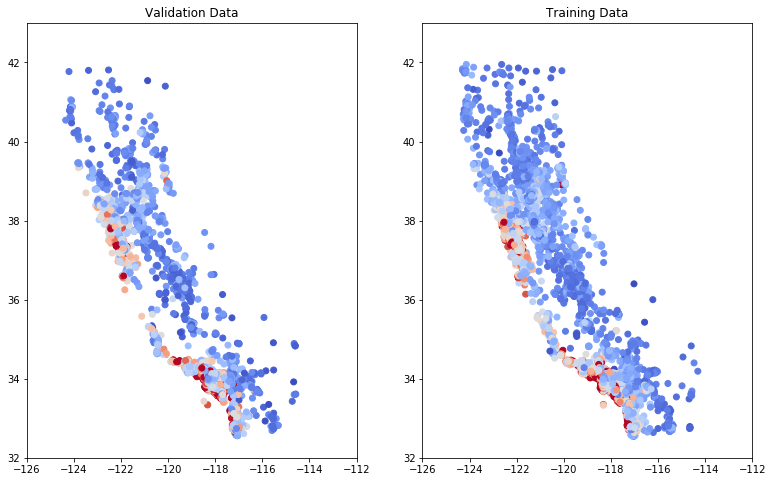

In [23]:
plt.figure(figsize=(13, 8))

ax = plt.subplot(1, 2, 1)
ax.set_title("Validation Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(validation_examples["longitude"],
           validation_examples["latitude"],
           cmap="coolwarm",
           c=validation_targets["median_house_value"] / validation_targets["median_house_value"].max())

ax = plt.subplot(1, 2, 2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
           training_examples["latitude"],
           cmap="coolwarm",
           c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

_ = plt.plot()

## Task 4: Train and Evaluate a Model
Next, we'll train a linear regressor using all features in the data set, and see how well we do.

Let's define the same input function we've used previously for loading the data into a TensorFlow model.

In [24]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
    
    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
        shuffle: True or False. Whether to shuffle the data.
        num_epochs: Numer of epochs for which data should be repeated. None = repeat indefinitley
    Returns:
        Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key, value in dict(features).items()}
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
        
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

Because we're now working with multiple input features, let's modularize our code for configuring feature columns into a seperate funcition. (For now, this code is fairly simple, as all our features are numeric, but we'll build on this code as we use other types of features in future exercise.)

In [25]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """
    return set([tf.feature_column.numeric_column(my_feature)
               for my_feature in input_features])

Next, go ahead and complete the `train_model()` code to set up input functions and calculate predictions.

Compare the losses on training data and validation data. With a single raw feature, our best RMSE was about 180.

See how much better you can do now that we can use multiple features.

Check the data using some of the methods we've looked at before. This could include:
  - Comparing distributions of predictions and actual target values
  - Creating a scatter plot of predictions vs. target values
  - Creating two scatter plots of validation data using `longitute` and `latitude`
    - One plot mapping colour to actual target `median_house_value`
    - A second plot mapping colour to predicted `median_house_value` for side-by-side comparison.

In [30]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
    """Trains a linear regression model of multiple features
    
    In addition to training, this function also prints traiing progress information,
    as well as a plot of the training and validation loss over time.
    
    Args:
        learning_rate: A `float`, the learning rate
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch
        batch_size: A non-zero `int`, the batch size
        training_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            `california_housing_dataframe` to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            `california_housing_dataframe` to use as target for validation.
            
    Returns:
        A `LinearRegressor` object trained on the training data
    """
    
    periods = 10
    steps_per_period = steps / periods
    
    # Create a linear regressor object.
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    # 1. Create input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets["median_house_value"],
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples,
        training_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples,
        validation_targets["median_house_value"],
        num_epochs=1,
        shuffle=False)
    
    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        # 2. Take a break and compute predictions.
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        # Compute training and validation loss.
        training_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(validation_predictions, validation_targets))
        # Occasionally print the current loss.
        print("    period %02d : %0.2f" % (period, training_root_mean_squared_error))
        # Add the loss metrics from this period to our list.
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
    print("Model training finished.")
    
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor

Training model...
RMSE (on training data):
    period 00 : 217.64
    period 01 : 200.65
    period 02 : 186.98
    period 03 : 177.27
    period 04 : 171.91
    period 05 : 167.76
    period 06 : 167.20
    period 07 : 167.78
    period 08 : 169.01
    period 09 : 170.33
Model training finished.


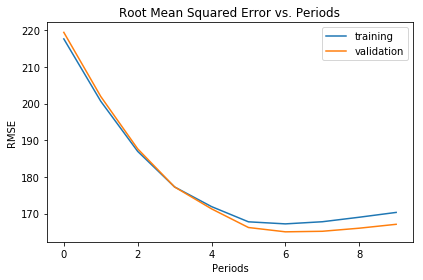

In [38]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

## Task 5: Evaluate on Test Data
We've done a lot of iteration on our validation data. Let's make sure we haven't overfit to the pecularities of that particular sample.

How does the test peformance compare to the validation performance? What does this say about the generalization performance of the model?

In [44]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(
    test_examples,
    test_targets["median_house_value"],
    num_epochs=1,
    shuffle=False
)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print("Finale RMSE (on test data): %0.2f" % root_mean_squared_error)

Finale RMSE (on test data): 162.60
